## **Building a bb8 droid**

Installing package into 'C:/Users/Lenovo/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'rgeos' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Lenovo\AppData\Local\Temp\Rtmp2BlMSw\downloaded_packages


rgeos version: 0.5-2, (SVN revision 621)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 
 Linking to sp version: 1.3-2 
 Polygon checking: TRUE 


Warning message:
"`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session."


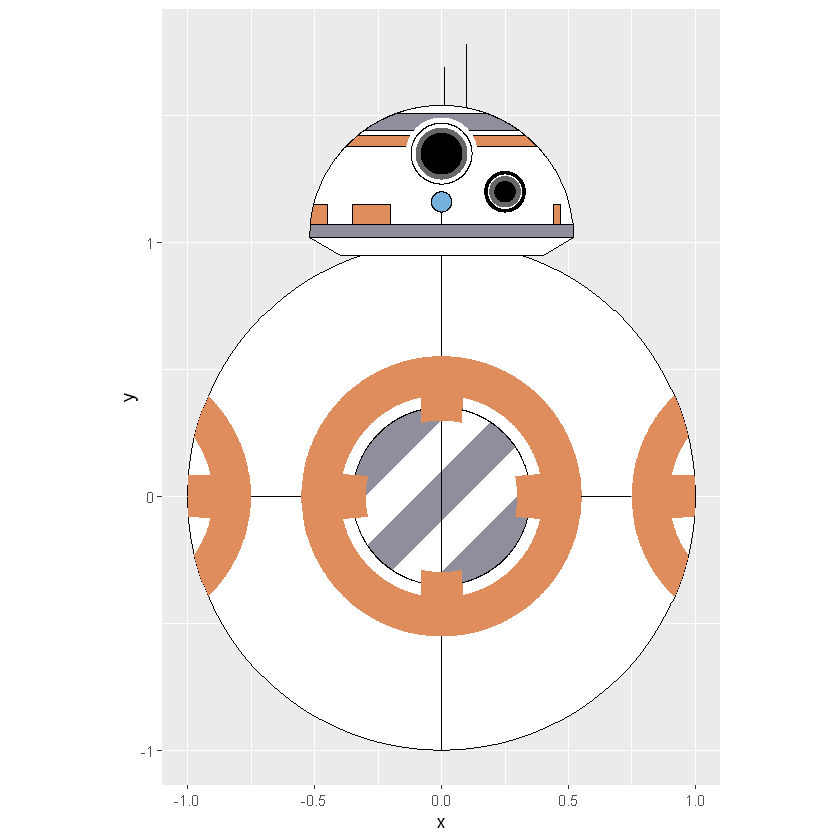

In [3]:
install.packages("rgeos")
# Packages ----------------------------------------------------------------

library("dplyr")
library("ggplot2")
library("sp")
library("rgeos")


# Funs --------------------------------------------------------------------

coord_circle <- function(centre = c(0, 0), r = 1, n = 1000) {
  data_frame(
    x = seq(from = 0 - r, to = 0 + r, length.out = n %/% 2),
    y = sqrt(r^2 - x^2)
  ) %>% bind_rows(., -.) %>%
    mutate(x = x + centre[1], y = y + centre[2])
}


create_poly <- function(...) {
  args <- list(...)
  SpatialPolygons(
    lapply(
      X = seq_along(args),
      FUN = function(x) {
        Polygons(list(Polygon(as.data.frame(args[[x]]))), names(args)[x])
      }
    )
  )
}


echancrure <- function(to_var, by_var, p = 0.1) {
  ind <- which(by_var >= -0.08 & by_var <= 0.08 & to_var > 0)
  to_var[ind] <- to_var[ind] - p
  ind <- which(by_var >= -0.08 & by_var <= 0.08 & to_var < 0)
  to_var[ind] <- to_var[ind] + p
  return(to_var)
}



# BB-8 geometries ---------------------------------------------------------


# droid_body -------------------------------------------------------------------

# shape of the droid_body : two circles and a vertical line
droid_body <- coord_circle(centre = c(0, 0), r = 1)
droid_body$xvert <- 0
droid_body$yvert <- droid_body$x
droid_body <- bind_cols(
  droid_body,
  coord_circle(centre = c(0, 0), r = 0.35, n = nrow(droid_body)) %>% select(xint = x, yint = y)
)

# grey shapes in the central inner circle
droid_body_rect <- data_frame(
  x = c(-0.5, 0.5, 0.5, -0.5, c(-0.5, 0.5, 0.5, -0.5) - 0.2, c(-0.5, 0.5, 0.5, -0.5) + 0.2),
  y = c(-0.6, 0.4, 0.6, -0.4, c(-0.6, 0.4, 0.6, -0.4) + 0.2, c(-0.6, 0.4, 0.6, -0.4) - 0.2),
  group = rep(1:3, each = 4)
)
# a polygon for calculate the intersection between the grey shapes and the inner circle
polyrect <- create_poly(
  "polyrect1" = droid_body_rect[droid_body_rect$group == 1, 1:2],
  "polyrect2" = droid_body_rect[droid_body_rect$group == 2, 1:2],
  "polyrect3" = droid_body_rect[droid_body_rect$group == 3, 1:2]
)
polycircle <- create_poly(
  "polycircle" = droid_body[, c("xint", "yint")]
)
# plot(polyrect); plot(polycircle, add = TRUE)
polyrect <- gIntersection(spgeom1 = polyrect, spgeom2 = polycircle)
# plot(polyrect); plot(polycircle, add = TRUE)

# fortify the polygon for ggplot
droid_body_rect <- fortify(polyrect)


# Central ring (orange)
ring <- coord_circle(centre = c(0, 0), r = 0.4)
ring$y <- echancrure(to_var = ring$y, by_var = ring$x, p = 0.1)
ring$x <- echancrure(to_var = ring$x, by_var = ring$y, p = 0.1)
ring <- bind_rows(
  ring %>% mutate(group = (x >= 0) * 1),
  coord_circle(centre = c(0, 0), r = 0.55, n = nrow(ring)) %>% mutate(y = -y, group = (x >= 0) * 1)
) %>%
  filter(group == 1) # oups something went wrong
ring <- bind_rows(ring, ring %>% mutate(x = -x, group = 2))




# ring left and right
# we make a copy of the right part of the central ring
ring_left <- ring %>% filter(group == 1)
# and we shift the ring center
ring_left$x <- ring_left$x - 1.3

# the same ...
ring_right <- ring %>% filter(group == 2)
ring_right$x <- ring_right$x + 1.3

# we creta a polygon for the intersection with the droid_body circle
polyring <- create_poly(
  "polyring_g" = ring_left[, c("x", "y")],
  "polyring_d" = ring_right[, c("x", "y")]
)

polydroid_body <- create_poly("polydroid_body" = droid_body[, c("x", "y")])

# plot(polyring); plot(polydroid_body, add = TRUE)

polyring <- gIntersection(spgeom1 = polyring, spgeom2 = polydroid_body)
fort_ring <- fortify(polyring)


# the horizontal line of the body (in two parts)
ligne_hori <- data_frame(
  x = c(-1, range(ring$x), 1),
  y = 0,
  group = c(1, 1, 2, 2)
)


# droid head --------------------------------------------------------------------

droid_head <- coord_circle(centre = c(0, 1.02), r = 0.52) %>%
  filter(y >= 1.02) %>%
  mutate(group = 1, fill = "white", col= "black") %>%
  bind_rows(
    data_frame(
      x = c(-0.52, -0.4, 0.4, 0.52),
      y = c(1.02, 0.95, 0.95, 1.02),
      group = 2, fill = "white", col= "black"
    )
  )
# Grey bars in droid's head
poly_head_grey <- create_poly(
  "poly_head_grey_haut" = data_frame(
    x = c(-0.52, 0.52, 0.52, -0.52),
    y = c(1.44, 1.44, 1.51, 1.51)
  ),
  "poly_head_grey_bas" = data_frame(
    x = c(-0.52, 0.52, 0.52, -0.52),
    y = c(1.02, 1.02, 1.07, 1.07)
  )
)

polydroid_head <- create_poly("polydroid_head" = droid_head[droid_head$group == 1, c("x", "y")])

poly_head_grey <- gIntersection(spgeom1 = poly_head_grey, spgeom2 = polydroid_head)
fort_droid_headrectgris <- fortify(poly_head_grey)



# orange bars
poly_head_orange <- create_poly(
  "poly_head_orange1" = data_frame(
    x = c(-0.52, 0.52, 0.52, -0.52),
    y = c(1.38, 1.38, 1.42, 1.42)
  ),
  "poly_head_orange2" = data_frame(
    x = c(-0.35, -0.35, -0.2, -0.2),
    y = c(1.07, 1.15, 1.15, 1.07)
  ),
  "poly_head_orange3" = data_frame(
    x = c(-0.55, -0.55, -0.45, -0.45),
    y = c(1.07, 1.15, 1.15, 1.07)
  ),
  "poly_head_orange4" = data_frame(
    x = c(0.44, 0.44, 0.47, 0.47),
    y = c(1.07, 1.15, 1.15, 1.07)
  )
)

poly_head_orange <- gIntersection(spgeom1 = poly_head_orange, spgeom2 = polydroid_head)
fort_droid_headrectorange <- fortify(poly_head_orange)


polygones_droid_head <- bind_rows(
  fort_droid_headrectgris %>% select(-piece) %>%
    mutate(group = as.numeric(as.character(group)), fill = "#8E8E9C", col= "black"),
  fort_droid_headrectorange %>% select(-piece) %>% 
    mutate(group = as.numeric(as.character(group)) * 2, fill = "#DF8D5D", col= "black")
)


# Eyes
droid_eyes <- bind_rows(
  coord_circle(centre = c(0, 1.35), r = 0.14) %>% mutate(group = 1, fill = "white", col = "white"),
  coord_circle(centre = c(0, 1.35), r = 0.12) %>% mutate(group = 2, fill = "white", col = "black"),
  coord_circle(centre = c(0, 1.35), r = 0.10) %>% mutate(group = 3, fill = "grey40", col = "grey40"),
  coord_circle(centre = c(0, 1.35), r = 0.08) %>% mutate(group = 4, fill = "black", col = "black"),
  coord_circle(centre = c(0, 1.16), r = 0.04) %>% mutate(group = 5, fill = "#76B1DE", col = "black"),
  coord_circle(centre = c(0.25, 1.20), r = 0.08) %>% mutate(group = 6, fill = "black", col = "black"),
  coord_circle(centre = c(0.25, 1.20), r = 0.07) %>% mutate(group = 7, fill = "white", col = "black"),
  coord_circle(centre = c(0.25, 1.20), r = 0.06) %>% mutate(group = 8, fill = "grey40", col = "grey40"),
  coord_circle(centre = c(0.25, 1.20), r = 0.04) %>% mutate(group = 9, fill = "black", col = "black")
)

eye_line <- data_frame(
  x = 0,
  y = c(1.07, 1.16-0.04)
)

# Antennas
antennas <- data_frame(
  x = c(0.01, 0.01, 0.10, 0.10),
  y = c(sqrt(0.52^2 - 0.01^2) + 1.02, sqrt(0.52^2 - 0.01^2) + 1.02 + 0.15,
        sqrt(0.52^2 - 0.1^2) + 1.02, sqrt(0.52^2 - 0.1^2) + 1.02 + 0.25),
  group = c(1, 1, 2, 2)
)


# bb-8/ggplot2 ------------------------------------------------------------

bb8 <- ggplot(data = droid_body) +
  coord_fixed() +
  geom_polygon(mapping = aes(x = x, y = y), fill = "white", col = "black") +
  geom_polygon(data = droid_body_rect, mapping = aes(x = long, y = lat, group = group), fill = "#8E8E9C") +
  geom_path(mapping = aes(x = xvert, y = yvert)) +
  geom_path(mapping = aes(x = xint, y = yint)) +
  geom_polygon(data = ring, mapping = aes(x = x, y = y, group = group), fill = "#DF8D5D", col = "#DF8D5D") +
  geom_path(data = ligne_hori, mapping = aes(x = x, y = y, group = group)) +
  geom_polygon(data = fort_ring , mapping = aes(x = long, y = lat, group = group), fill = "#DF8D5D") +
  geom_polygon(data = droid_head, mapping = aes(x = x, y = y, group = group, fill = fill, col = col)) +
  geom_polygon(data = polygones_droid_head, mapping = aes(x = long, y = lat, group = group, fill = fill, col = col)) +
  geom_polygon(data = droid_eyes, mapping = aes(x = x, y = y, group = group, fill = fill, col = col)) +
  scale_fill_identity() + scale_color_identity() +
  geom_line(data = eye_line, mapping = aes(x = x, y = y)) +
  geom_line(data = antennas, mapping = aes(x = x, y = y, group = group), col = "black")


bb8
# or
#bb8 + theme_void()